# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [21]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def ru(relevant: List[int], predicted: List[int], k: int = 20):
    return np.isin(predicted[:k], relevant)

def puk(relevant: List[int], predicted: List[int], k: int = 20):
    return np.cumsum(ru(relevant, predicted, k))/np.arange(1, k+1)

def apuk(relevant: List[int], predicted: List[int], k: int = 20):
    return np.sum(ru(relevant, predicted, k)*puk(relevant, predicted, k))/min(k, len(relevant))

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    sum = 0
    for u in range(len(relevant)):
        sum += apuk(relevant[u], predicted[u], k)
    return sum/len(relevant)

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user in range(self.n_users):
            test_preds.append(self.recommend(user))
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [24]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    numerator = ratings @ user_vector
    denominator = np.linalg.norm(ratings, axis=1)*np.linalg.norm(user_vector)

    similarity = numerator / denominator
    similarity[denominator == 0] = 0

    return similarity


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = np.logical_and(user_vector, ratings).sum(axis=1)
    union = np.logical_or(user_vector, ratings).sum(axis=1)
    similarity = intersection/union
    similarity[union == 0] = 0

    return similarity

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [17]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        sim[uid] = 0
        sim_users_indexes = np.where(sim > self.alpha)[0]

        return np.argsort(-sim[sim_users_indexes] @ self.R[sim_users_indexes])

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

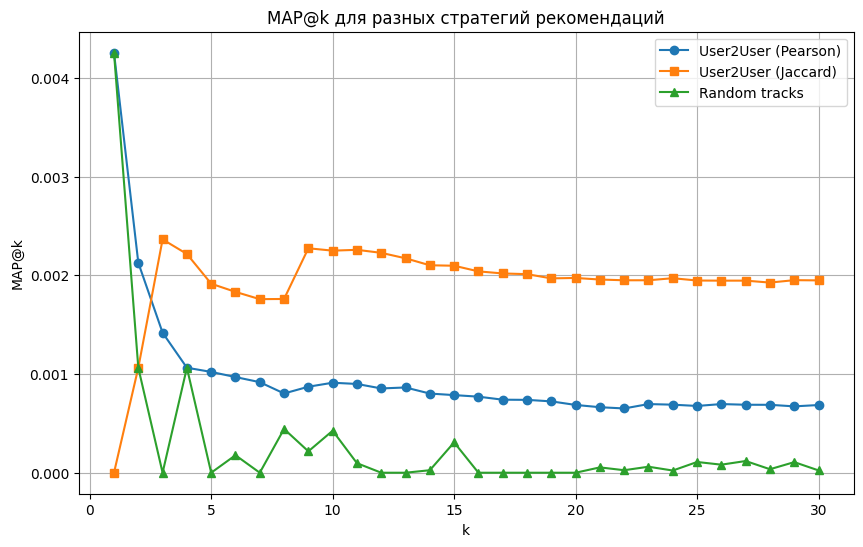

In [26]:
col_filtr_pearson = User2User(train_ratings, similarity_func=pearson)
col_filtr_jaccard = User2User(train_ratings, similarity_func=jaccard)

k_max = 30

mapk_pearson = []
mapk_jaccard = []
mapk_random = []

for k in range(1, k_max+1):
    rec_pearson = col_filtr_pearson.get_test_recommendations(k)
    rec_jaccard = col_filtr_jaccard.get_test_recommendations(k)
    rec_random = np.random.choice(np.unique(train_ratings['trackId']), size=(len(test_users), k))

    mapk_pearson.append(mapk(test_relevant, rec_pearson, k))
    mapk_jaccard.append(mapk(test_relevant, rec_jaccard, k))
    mapk_random.append(mapk(test_relevant, rec_random, k))

plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), mapk_pearson, label='User2User (Pearson)', marker='o')
plt.plot(range(1, k_max + 1), mapk_jaccard, label='User2User (Jaccard)', marker='s')
plt.plot(range(1, k_max + 1), mapk_random, label='Random tracks', marker='^')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k для разных стратегий рекомендаций')
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** Лучшим оказался способ рекомендации, основанный на мере Жаккара, он в среднем выдает метрику 0.002, тогда как рандомный подход показывает наихудший результат среди трех методов, в среднем map@k около 0.0001, но иногда бывают более удачные рекомендации (при k=1, 4). Подход основанный на корреляции Пирсона выдает наивысшие результаты только при k=1, 2, а далее находится между результами случайного подхода и подхода, основанного на мере Жаккара, метрика в среднем меньше чуть 0.001.

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [27]:
from scipy.sparse import csr_matrix

In [28]:
class BaseModel_sparse:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = csr_matrix((np.ones(len(ratings)), (ratings['userId'], ratings['trackId'])), shape=(self.n_users, self.n_items))

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user in range(self.n_users):
            test_preds.append(self.recommend(user))
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

In [50]:
def pearson_sparse(ratings: csr_matrix, user_vector: np.array) -> np.array:
    numerator = ratings.dot(user_vector.T).toarray().ravel()

    ratings_norms = np.sqrt(ratings.multiply(ratings).sum(axis=1)).A1
    user_norm = np.sqrt(user_vector.multiply(user_vector).sum())

    denominator = ratings_norms*user_norm

    similarity = numerator / denominator
    similarity[denominator == 0] = 0

    return similarity

def jaccard_sparse(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
    ratings_bin = ratings.astype(bool)
    user_bin = user_vector.astype(bool)

    intersection = ratings_bin.multiply(user_bin).sum(axis=1).A1
    union = ratings_bin.sum(axis=1).A1 + user_bin.sum() - intersection
    similarity = intersection/union
    similarity[union == 0] = 0

    return similarity

In [30]:
class User2User_sparse(BaseModel_sparse):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson_sparse, jaccard_sparse]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: csr_matrix):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        sim[uid] = 0
        sim_users_indexes = np.where(sim > self.alpha)[0]

        return np.argsort(-sim[sim_users_indexes] @ self.R[sim_users_indexes])

In [51]:
import time

start = time.time()
model_dense = User2User(train_ratings, similarity_func=pearson)
recs_dense = model_dense.get_test_recommendations(15)
print(f'Оригинальный подход: {time.time() - start:.2f} сек')

start = time.time()
model_sparse = User2User_sparse(train_ratings, similarity_func=pearson_sparse)
recs_sparse = model_sparse.get_test_recommendations(15)
print(f"Разреженный подход: {time.time() - start:.2f} сек")

assert np.allclose(recs_dense, recs_sparse)

Оригинальный подход: 39.01 сек
Разреженный подход: 1.47 сек


In [34]:
import time

start = time.time()
model_dense = User2User(train_ratings, similarity_func=jaccard)
recs_dense = model_dense.get_test_recommendations(15)
print(f'Оригинальный подход: {time.time() - start:.2f} сек')

start = time.time()
model_sparse = User2User_sparse(train_ratings, similarity_func=jaccard_sparse)
recs_sparse = model_sparse.get_test_recommendations(15)
print(f"Разреженный подход: {time.time() - start:.2f} сек")

assert np.allclose(recs_dense, recs_sparse)

Оригинальный подход: 39.76 сек
Разреженный подход: 2.24 сек


**Вывод:** время работы снизилось в 20 раза для подхода, основанном на мере Жаккара, и в 26.5 раз для метода, основанном на корреляции Пирсона.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [286]:
user_id = np.random.randint(0, col_filtr_jaccard.n_users)

In [287]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
234,Wind Of Change,['Scorpions']
1799,Люблю-прощай,['Вячеслав Бутусов']
1804,Ночь,['КИНО']
1805,Игра,['КИНО']
1826,Тёплые коты,['Flёur']
1920,Асфальт,['КИНО']
1921,Восьмиклассница,['КИНО']
1922,Солнечные дни,['КИНО']
1941,Это не любовь,['КИНО']
1965,Падающая звезда,['Кукрыниксы']


In [288]:
preds = col_filtr_jaccard.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2555,Californication,['Red Hot Chili Peppers']
5521,Полковнику никто не пишет,['Би-2']
1131,The Unforgiven,['Metallica']
10282,Владивосток 2000,['Мумий Тролль']
234,Wind Of Change,['Scorpions']
33436,Believer,['Imagine Dragons']
6745,Chop Suey!,['System of A Down']
49577,Кукла колдуна,['Король и Шут']
6841,Lonely Day,['System of A Down']
4744,Hero,['Skillet']


In [289]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
21636,Я верю,['30.02']
22026,Человек хороший,['Вася Обломов']
23573,California Dreamin',['Sia']
23690,В облаках у водопада,['Александр Иванов']
23944,Трасса Е-95,['Алиса']
24209,Братишка,['Пилот']
24604,От Кореи до Карелии,['Пикник']
26074,Воздух,['Сурганова и Оркестр']
26130,31-я весна,['Ночные Снайперы']
26177,Ты дарила мне розы,['Ночные Снайперы']


**Вывод:** Рекомендации получились такими себе, но песни Полковнику никто не пишет ['Би-2'] и Владивосток 2000	['Мумий Тролль'] соответсвуют жанру рок, который предпочитает слушать данный пользователь.

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Вспомните формулы обновления и поясните их:

**SGD:**

Сэмплируем $(u, i)$ из $R$ так, что $r_{ui} \neq 0$

Градиент по $p_u$:

$\nabla_{p_u} L = 2(p_u^\top q_i - r_{ui}) q_i + 2\lambda p_u$

Градиент по $q_i$:

$\nabla_{q_i} L = 2(q_i^\top p_u - r_{ui}) p_u + 2\lambda q_i$

**Ответ:**

Обновление $p_u$:

$p_u = p_u - \eta ((p_u^\top q_i - r_{ui}) q_i + \lambda p_u)$

Обновление $q_i$:

$q_i = q_i - \eta ((q_i^\top p_u - r_{ui}) p_u + \lambda q_i)$

**ALS:**

Для фиксированного $Q$, берём градиент по $p_u$ и приравниваем к нулю:

$\nabla_{p_u} L = 2\sum_{i} (p_u^\top q_i - r_{ui}) q_i + 2\lambda p_u = 0$

Не забываем проверить, что $r_{ui} \neq 0$

Воспользовавшись тем, что $a^\top b c = c b^\top a$, получим:

$\sum_{i} q_i q_i^\top p_u + \lambda p_u = \sum_{i} r_{ui} q_i$

Вынесем $p_u$:

$\left( \sum_{i} q_i q_i^\top + \lambda I \right) p_u = \sum_{i} r_{ui} q_i$

Ответ:

Тогда окончательно каждый столбец матрицы $P$ можно найти по формуле:

$p_u = \left( \sum_{i} q_i q_i^\top + \lambda I \right)^{-1} \left( \sum_{i} r_{ui} q_i \right) \quad \forall u$

Аналогично для столбцов матрицы $Q$:

$q_i = \left( \sum_{u} p_u p_u^\top + \lambda I \right)^{-1} \left( \sum_{u} r_{ui} p_u \right) \quad \forall i$

**Задание 8 (2 балла).** А теперь реализуйте методы оптимизации параметров для обоих алгоритмов.

In [290]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                nonzero_indices = np.array(self.R.nonzero()).T

                u, i = nonzero_indices[np.random.randint(len(nonzero_indices))]
                r_ui = self.R[u, i]

                self.P[u] -= self.lr * ((self.P[u] @ self.Q[i] - r_ui) * self.Q[i] + self.lamb * self.P[u])
                self.Q[i] -= self.lr * ((self.P[u] @ self.Q[i] - r_ui) * self.P[u] + self.lamb * self.Q[i])

            elif self.mode == 'als':
                for u in range(self.n_users):
                    nonzero_indices = self.R[u, :] > 0
                    Q_i = self.Q[nonzero_indices]
                    R_u = self.R[u, nonzero_indices]

                    if len(R_u) > 0:
                        self.P[u] = np.linalg.solve(Q_i.T @ Q_i + self.lamb * np.eye(self.dim), Q_i.T @ R_u)

                for i in range(self.n_items):
                    nonzero_indices = self.R[:, i] > 0
                    P_u = self.P[nonzero_indices]
                    R_i = self.R[nonzero_indices, i]

                    if len(R_i) > 0:
                        self.Q[i] = np.linalg.solve(P_u.T @ P_u + self.lamb * np.eye(self.dim), P_u.T @ R_i)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
num_iters_range = np.arange(5, 206, 10)
dim_values = [32, 64, 96, 128, 192, 256]
k_values = np.arange(1, 51)

results = []

for num_iters in num_iters_range:
    print(f"\nДля num_iters = {num_iters}")

    best_overall = {
        'map@k': -1,
        'dim': None,
        'k': None
    }

    for dim in dim_values:
        print(f"\ndim = {dim}")

        lfm = HiddenVars(train_ratings, dim=dim, mode='sgd')
        lfm.fit(num_iters)

        predictions = lfm.get_test_recommendations(k=50)

        for k in k_values:
            score = mapk(test_relevant, predictions, k)

            if score > best_overall['map@k']:
                best_overall.update({
                    'map@k': score,
                    'dim': dim,
                    'k': k
                })

    print('\nНаивысший map@k для данного num_iters:', best_overall['map@k'])

    results.append({
        'num_iters': num_iters,
        'dim': best_overall['dim'],
        'k': best_overall['k'],
        'map@k': best_overall['map@k']
    })

results_df = pd.DataFrame(results)

best_row = results_df.loc[results_df['map@k'].idxmax()]
print("\nBest overall:")
print(best_row)


Для num_iters = 5

dim = 32


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/5 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 15

dim = 32


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/15 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/15 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 25

dim = 32


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/25 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 35

dim = 32


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/35 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/35 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0003375126646403242

Для num_iters = 45

dim = 32


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/45 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 55

dim = 32


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/55 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/55 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 65

dim = 32


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/65 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00017021276595744682

Для num_iters = 75

dim = 32


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/75 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/75 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 85

dim = 32


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/85 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00017021276595744682

Для num_iters = 95

dim = 32


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/95 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/95 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 105

dim = 32


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/105 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 115

dim = 32


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/115 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/115 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 125

dim = 32


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/125 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 135

dim = 32


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/135 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/135 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 145

dim = 32


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/145 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/145 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 155

dim = 32


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/155 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/155 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 165

dim = 32


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/165 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/165 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00047281323877068556

Для num_iters = 175

dim = 32


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/175 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/175 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 185

dim = 32


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/185 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/185 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.0010638297872340426

Для num_iters = 195

dim = 32


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/195 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/195 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00026595744680851064

Для num_iters = 205

dim = 32


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 128


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 192


  0%|          | 0/205 [00:00<?, ?it/s]


dim = 256


  0%|          | 0/205 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Best overall:
num_iters    105.000000
dim           32.000000
k              1.000000
map@k          0.004255
Name: 10, dtype: float64


In [ ]:
num_iters_range = np.arange(5, 206, 20)
dim_values = [16, 32, 64, 96]
k_values = np.arange(1, 51)

results = []

for num_iters in num_iters_range:
    print(f"\nДля num_iters = {num_iters}")

    best_overall = {
        'map@k': -1,
        'dim': None,
        'k': None
    }

    for dim in dim_values:
        print(f"\ndim = {dim}")

        lfm = HiddenVars(train_ratings, dim=dim, mode='als')
        lfm.fit(num_iters)

        predictions = lfm.get_test_recommendations(k=50)

        for k in k_values:
            score = mapk(test_relevant, predictions, k)

            if score > best_overall['map@k']:
                best_overall.update({
                    'map@k': score,
                    'dim': dim,
                    'k': k
                })

    print('\nНаивысший map@k для данного num_iters:', best_overall['map@k'])

    results.append({
        'num_iters': num_iters,
        'dim': best_overall['dim'],
        'k': best_overall['k'],
        'map@k': best_overall['map@k']
    })

results_df_als = pd.DataFrame(results)

best_row_als = results_df_als.loc[results_df_als['map@k'].idxmax()]
print("\nBest overall:")
print(best_row_als)


Для num_iters = 5

dim = 16


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/5 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/5 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 25

dim = 16


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/25 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/25 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00851063829787234

Для num_iters = 45

dim = 16


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/45 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/45 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00851063829787234

Для num_iters = 65

dim = 16


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/65 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/65 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.01276595744680851

Для num_iters = 85

dim = 16


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/85 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/85 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 105

dim = 16


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/105 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/105 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00851063829787234

Для num_iters = 125

dim = 16


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 32


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 64


  0%|          | 0/125 [00:00<?, ?it/s]


dim = 96


  0%|          | 0/125 [00:00<?, ?it/s]


Наивысший map@k для данного num_iters: 0.00425531914893617

Для num_iters = 145

dim = 16


  0%|          | 0/145 [00:00<?, ?it/s]

KeyboardInterrupt: 

Я дождался только до 125 итераций, ALS какой-то долгий.

In [ ]:
results_df_als = pd.DataFrame(results)

best_row_als = results_df_als.loc[results_df_als['map@k'].idxmax()]
print("\nBest overall:")
print(best_row_als)


Best overall:
num_iters    65.000000
dim          64.000000
k             1.000000
map@k         0.012766
Name: 3, dtype: float64


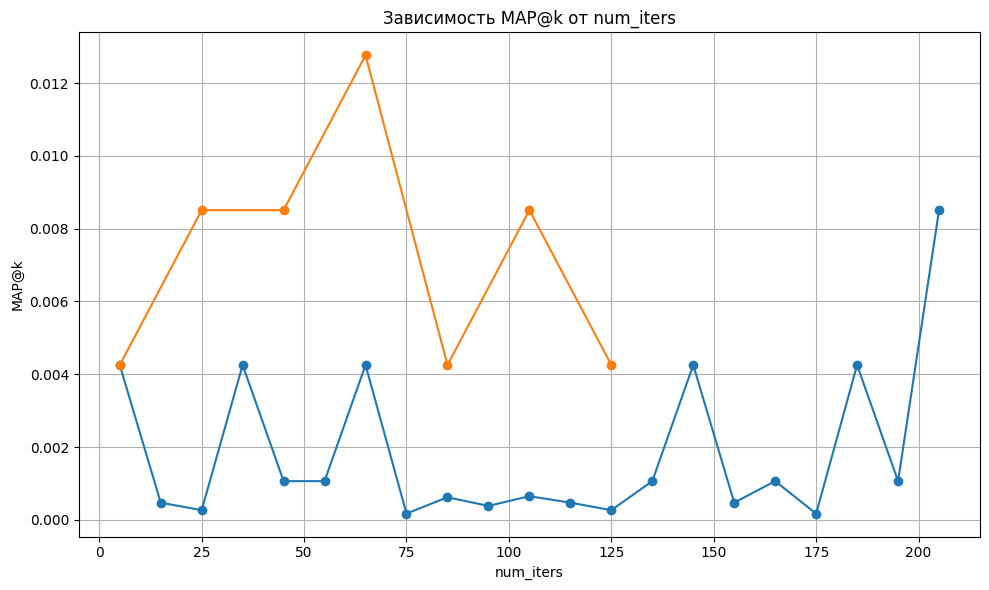

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['num_iters'], results_df['map@k'], marker='o', linestyle='-')
plt.plot(results_df_als['num_iters'], results_df_als['map@k'], marker='o', linestyle='-')
plt.xlabel('num_iters')
plt.ylabel('MAP@k')
plt.title('Зависимость MAP@k от num_iters')
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод:** По графику видно, что ALS показывает себя намного лучше SGD, который в некоторых моментах дает MAP@K близкий к нулю, а все остальные значения лежат не выше, чем любое значение метрики у ALS, кроме значения SGD > 0.008 на 200 итераций. Максимальное значение у ALS > 0.012, что в несколько раз превосходит максимальное значение у User2User. Таким образом, SGD только в половине случаев лучше, чем случайные рекомендации и User2User, но в этих случаях разница значительная (примерно в 2 раза для максимального MAP@K у User2User). ALS же даже в самых худших случаях показывает метрику в два раза выше, чем максимальная у User2User. Зависимость от количества итераций не очень очевидна, но можно заметить, что для SGD при 75-125 итераций метрика очень мала, но достигает пика после 200 итераций. Для ALS оптимальным кажется значение от 25 до 65 итераций.

Для данной задачи более подходящим кажется алгоритм ALS, так как он демонстрирует стабильные результаты при меньшем числе итераций и менее чувствителен к выбору гиперпараметров.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [295]:
model = HiddenVars(train_ratings, dim=64, mode='als')
model.fit(65)

  0%|          | 0/65 [00:00<?, ?it/s]

In [296]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.618704
2179,Восьмиклассница,['КИНО'],0.559896
9433,В последнюю осень,['ДДТ'],0.543373
31388,Мой рок-н-ролл,"['Би-2', 'Чичерина']",0.533966
5515,Романс,['Сплин'],0.498995
19430,Вечная молодость,['Чиж & Co'],0.497706
14871,Никто не услышит (Ой-йо),['ЧайФ'],0.497303
9444,Ветер,['ДДТ'],0.496497
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.493584


**Вывод:** Видим, что получилось намного лучше: есть одна рекомендация от того же автора, большинство предложенных треков относятся к русскому року, как и жанр исходного трека. Такие группы в рекомендациях как КИНО, ДДТ, Би-2, Наутилус Помпилиус говорит о хорошем семантическом попадании. Также в списке встречаются композиции от западных рок-групп, что добавляет разнообразия, но при этом сохраняет жанровую близость.